The Notebook for training BERT base model on the dataset made by Filtering Comparative Questions from SQuAD dataset

In [ ]:
 pip install transformers

In [ ]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
MODEL_PATH = "bert-base-uncased"

In [ ]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-12-01 20:37:01--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   239MB/s    in 0.2s    

2023-12-01 20:37:02 (239 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2023-12-01 20:37:02--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [ ]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [ ]:
def get_data(path):
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_file = open('/content/drive/MyDrive/OELP_BERT/BERT_SQuad/new_squad_train_w_valid.json')

new_data = json.load(dataset_file)

In [ ]:
num_q = 0
num_pos = 0
num_imp = 0
train_contexts = []
train_questions = []
train_answers = []
new_answers = []
new_answer_start = []

for i in range(len(new_data)):
  train_contexts.append(new_data[i]["sentence"])
  train_questions.append(new_data[i]['question'])
  new_answers.append(new_data[i]['answer'])
  new_answer_start.append(new_data[i]['answer_start'])
  train_answers.append({ 'text': new_answers[-1], 'answer_start': new_answer_start[-1]})

  num_q += 1
  if(0):
    num_imp += 1
  else:
    num_pos += 1

num_questions = num_q
num_posible = num_pos
num_impossible = num_imp


In [ ]:
print(f"numq is {num_q}")
print(f"num_pos is {num_pos}")
print(f"num_imp is {num_imp}")

numq is 243
num_pos is 243
num_imp is 0


In [ ]:
print(train_questions[0:10])
print(train_answers[0:10])

['when did jay z and beyoncé become the first music couple worth over a billion dollars?', "only a few of chopin's pieces involve more than the piano, including piano concertos, songs and what?", 'in the 1930s, new york city had more than 10 million people becoming the first what in history?', 'how many buildings located in nyc are at least 330 feet in height?', 'in what year did the city have less than 500 homicides?', 'what drives the plot of the book more than the characters?', "less than 1% of the world's total grid electricity was generated by solar energy in what year?", 'a program in los angeles believes that with $1 billion, city temperatures could be reduced by approximately how many degrees in celsius?', 'which celebrity sued west in 2006 for trademark infrigement?', 'what buddhist movement has linked more than 12 million people?']
[{'text': '2013', 'answer_start': 1204}, {'text': 'chamber music.', 'answer_start': 210}, {'text': 'megacity', 'answer_start': 192}, {'text': '550

In [ ]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('dev-v2.0.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 12116
Total number of Answerable questions: 6171
Total number of impossible questions: 5945


In [ ]:
print(valid_questions[0:10])
print(valid_answers[0:10])

['in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'from which countries did the norse originate?', 'from which countries did the norse originate?']
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'in the 10th and 11th centuries', 'answer_start': 87}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}]


In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [ ]:

print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: forbes magazine began reporting on beyoncé's earnings in 2008, calculating that the $80 million earned between june 2007 to june 2008, for her music, tour, films and clothing line made her the world's best-paid music personality at the time, above madonna and celine dion. they placed her fourth on the celebrity 100 list in 2009 and ninth on the most powerful women in the world list in 2010. the following year, forbes placed her eighth on the best-paid celebrities under 30 list, having earned $35 million in the past year for her clothing line and endorsement deals. in 2012, forbes placed beyoncé at number 16 on the celebrity 100 list, twelve places lower than three years ago yet still having earned $40 million in the past year for her album 4, clothing line and endorsement deals. in the same year, beyoncé and jay z placed at number one on the world's highest-paid celebrity couples, for collectively earning $78 million. the couple made it into the previous year's guinness world 

In [ ]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: the english name "normans" comes from the french words normans/normanz, plural of normant, modern french normand, which is itself borrowed from old low franconian nortmann "northman" or directly from old norse norðmaðr, latinized variously as nortmannus, normannus, or nordmannus (recorded in medieval latin, 9th century) to mean "norseman, viking".
Question: what is the original meaning of the word norman?
Answer: {'text': 'norseman, viking', 'answer_start': 331, 'answer_end': 347}


356


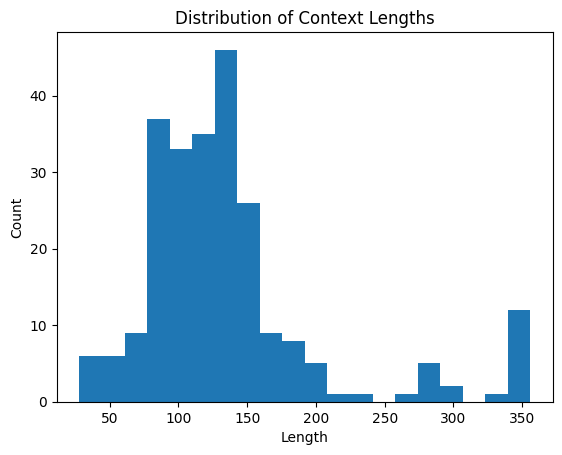

In [ ]:
token_lens = []

for txt in train_contexts:
    txt = txt.strip()
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

31
243


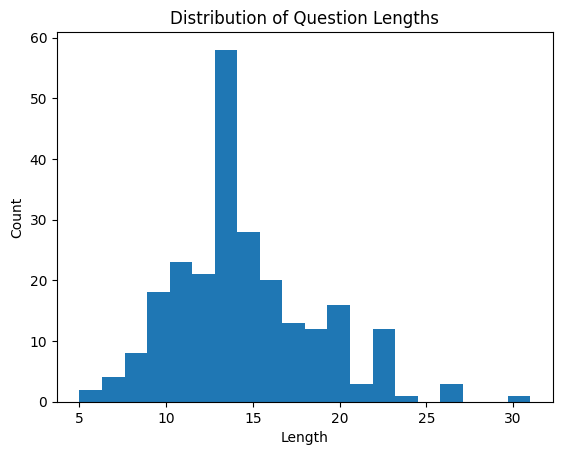

In [ ]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 250

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][1]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
243
250


In [ ]:
print(train_encodings_fast['input_ids'][1])
print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(train_encodings_fast['input_ids'][1])))

[101, 2069, 1037, 2261, 1997, 25479, 1005, 1055, 4109, 9125, 2062, 2084, 1996, 3682, 1010, 2164, 3682, 10405, 2015, 1010, 2774, 1998, 2054, 1029, 102, 2058, 11816, 2573, 1997, 25479, 5788, 1025, 2070, 9265, 2013, 2220, 5593, 2031, 2042, 2439, 1012, 2035, 2010, 2124, 2573, 9125, 1996, 3682, 1010, 1998, 2069, 1037, 2261, 2846, 3458, 3948, 3682, 2189, 1010, 2004, 2593, 3682, 10405, 2015, 1010, 2774, 2030, 4574, 2189, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] only a few of chopin ' s pie

In [ ]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
57 61
the cathars
the cathars
[CLS] who did prior diego admire more than the holy church? [SEP] prior diego saw immediately one of the paramount reasons for the spread of the unorthodox movement : the representatives of the holy church acted and moved with an offensive amount of pomp and ceremony. on the other hand, the cathars lived in a state of self - sacrifice that was widely appealing. for these reasons, prior diego suggested that the papal legates begin to live a reformed apostolic life. the legates agreed to change if they could find a strong leader. the prior took up the challenge, and he and dominic dedicated themselves to the conversion of the albigensians. despite this particular mission, in winning the albigensians over by persuasion dominic met limited success, for though in his ten years of preaching a large number of converts were made, it has to be said that the results were not such as had been hoped for. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
test_rec=1

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
67 70
chamber music.
chamber music.
[CLS] only a few of chopin's pieces involve more than the piano, including piano concertos, songs and what? [SEP] over 230 works of chopin survive ; some compositions from early childhood have been lost. all his known works involve the piano, and only a few range beyond solo piano music, as either piano concertos, songs or chamber music. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
243


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

5


In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
243


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

67
70
chamber music.
chamber music.
[CLS] only a few of chopin's pieces involve more than the piano, including piano concertos, songs and what? [SEP] over 230 works of chopin survive ; some compositions from early childhood have been lost. all his known works involve the piano, and only a few range beyond solo piano music, as either piano concertos, songs or chamber music. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

393


In [ ]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

france
france
[CLS] in what country is normandy located? [SEP] the normans ( norman : nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ( " norman " comes from " norseman " ) raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman - gaulish populations, their descendants would gradually merge with the carolingian - based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
243
243
243
20302
20302
20302


In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

"[CLS] when did jay z and beyonce become the first music couple worth over a billion dollars? [SEP] forbes magazine began reporting on beyonce's earnings in 2008, calculating that the $ 80 million earned between june 2007 to june 2008, for her music, tour, films and clothing line made her the world's best - paid music personality at the time, above madonna and celine dion. they placed her fourth on the celebrity 100 list in 2009 and ninth on the most powerful women in the world list in 2010. the following year, forbes placed her eighth on the best - paid celebrities under 30 list, having earned $ 35 million in the past year for her clothing line and endorsement deals. in 2012, forbes placed beyonce at number 16 on the celebrity 100 list, twelve places lower than three years ago yet still having earned $ 40 million in the past year for her album 4, clothing line and endorsement deals. in the same year, beyonce and jay z placed at number one on the world's highest - paid celebrity couple

In [ ]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

yonc


In [ ]:
answer_start_index = 0
answer_end_index = 100

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

"[CLS] when did jay z and beyonce become the first music couple worth over a billion dollars? [SEP] forbes magazine began reporting on beyonce's earnings in 2008, calculating that the $ 80 million earned between june 2007 to june 2008, for her music, tour, films and clothing line made her the world's best - paid music personality at the time, above madonna and celine dion. they placed her fourth on the celebrity 100 list in 2009 and ninth on the most powerful women in the world list in 2010"

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:
print(len(train_dataset))
print(train_dataset[0].keys())

243
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
bert_model = BertModel.from_pretrained(MODEL_PATH)
class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model = QAModel()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    return ((fl_start + fl_end)/2)

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        #print(out_start)

        # for iter in range(16):
        #   print(tokenizerFast.decode(input_ids[iter]))

        # print(out_start.size())
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
        #print("\n")
        #print((type(start_positions)))
        #print(type(start_pred))

        # for iter in range(16):
        #   print("pred")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_pred[iter] : end_pred[iter]])))
        #   print("true ans")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_positions[iter] : end_positions[iter]])))

        #print(start_pred)
        #print(start_positions)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())

        #print(f"acc1 is {acc[-2]} acc2 is {acc[-1]}")
        #print("\n")

        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
    return(ret_acc)

In [ ]:
EPOCHS = 13

model.to(device)
curr_epoch = 0
for epoch in range(EPOCHS):
    curr_epoch += 1
    print(f"current epoch is {curr_epoch}")
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

current epoch is 1


Running Epoch : 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Train Accuracy: 0.057291666977107525      Train Loss: 5.236577183008194


Running Evaluation: 100%|██████████| 635/635 [04:52<00:00,  2.17it/s]


Validation Accuracy: 0.04822483128450048
current epoch is 2


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


Train Accuracy: 0.140625      Train Loss: 4.605100333690643


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.05841183915851623
current epoch is 3


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.16471354197710752      Train Loss: 4.0873734056949615


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.07108408325300442
current epoch is 4


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.2968750009313226      Train Loss: 3.3536973148584366


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.09856931947347686
current epoch is 5


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.43684895895421505      Train Loss: 2.434608466923237


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.14246695726875244
current epoch is 6


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.5703125      Train Loss: 1.577261082828045


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.14790846456692913
current epoch is 7


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.657552083954215      Train Loss: 1.167620413005352


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.16035925196850392
current epoch is 8


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.6796875009313226      Train Loss: 0.9086306355893612


Running Evaluation: 100%|██████████| 635/635 [05:04<00:00,  2.08it/s]


Validation Accuracy: 0.16001476377952756
current epoch is 9


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.7506510429084301      Train Loss: 0.7358317747712135


Running Evaluation: 100%|██████████| 635/635 [05:04<00:00,  2.09it/s]


Validation Accuracy: 0.14032972440944882
current epoch is 10


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


Train Accuracy: 0.78515625      Train Loss: 0.5761222862638533


Running Evaluation: 100%|██████████| 635/635 [05:04<00:00,  2.09it/s]


Validation Accuracy: 0.14628444881889763
current epoch is 11


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.7897135429084301      Train Loss: 0.5551589950919151


Running Evaluation: 100%|██████████| 635/635 [05:05<00:00,  2.08it/s]


Validation Accuracy: 0.15391240157480315
current epoch is 12


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.8131510429084301      Train Loss: 0.4736660160124302


Running Evaluation: 100%|██████████| 635/635 [05:04<00:00,  2.09it/s]


Validation Accuracy: 0.14936023622047245
current epoch is 13


Running Epoch : 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Train Accuracy: 0.8268229169771075      Train Loss: 0.4551453161984682


Running Evaluation: 100%|██████████| 635/635 [05:04<00:00,  2.08it/s]

Validation Accuracy: 0.14092027559055118


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
scheduler.get_last_lr()

[5.083731656658001e-06]

In [ ]:
print(train_acc)

0.8268229169771075


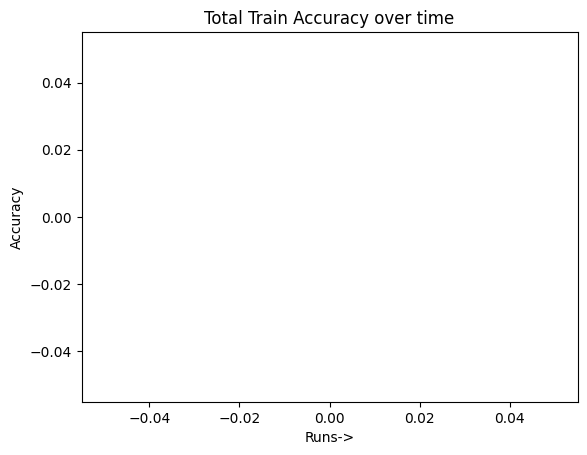

In [ ]:
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

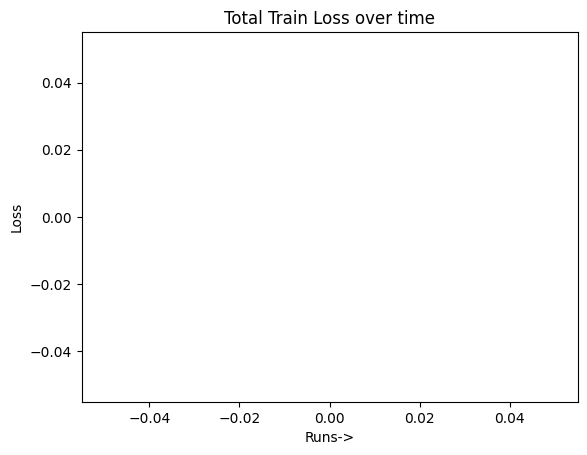

In [ ]:
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: in what country is normandy located?
Expected Answer: {'text': 'france', 'answer_start': 159, 'answer_end': 165}
Predicted Answer: nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave 

In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: who was the norse leader?
Expected Answer: {'text': 'rollo', 'answer_start': 308, 'answer_end': 313}
Predicted Answer: nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name t

In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: the norman dynasty had a major political, cultural and military impact on medieval europe and even the near east. the normans were famed for their martial spirit and eventually for their christian piety, becoming exponents of the catholic orthodoxy into which they assimilated. they adopted the gallo-romance language of the frankish land they settled, their dialect becoming known as norman, normaund or norman french, an important literary language. the duchy of normandy, which they formed by treaty with the french crown, was a great fief of medieval france, and under richard i of normandy was forged into a cohesive and formidable principality in feudal tenure. the normans are noted both for their culture, such as their unique romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. norman adventurers founded the kingdom of sicily under roger ii after conquering southern italy on the saracens and byzantines, and an exped

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: as of august 2010, victoria had 1,548 public schools, 489 catholic schools and 214 independent schools. just under 540,800 students were enrolled in public schools, and just over 311,800 in private schools. over 61 per cent of private students attend catholic schools. more than 462,000 students were enrolled in primary schools and more than 390,000 in secondary schools. retention rates for the final two years of secondary school were 77 per cent for public school students and 90 per cent for private school students. victoria has about 63,519 full-time teachers.
Question: how many full time teachers does victoria have?
Expected Answer: {'text': '63,519', 'answer_start': 541, 'answer_end': 547}
Predicted Answer: 63, 519 full - time teachers


In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: oxygen is more soluble in water than nitrogen is. water in equilibrium with air contains approximately 1 molecule of dissolved o
2 for every 2 molecules of n
2, compared to an atmospheric ratio of approximately 1:4. the solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·l−1) dissolves at 0 °c than at 20 °c (7.6 mg·l−1). at 25 °c and 1 standard atmosphere (101.3 kpa) of air, freshwater contains about 6.04 milliliters (ml) of oxygen per liter, whereas seawater contains about 4.95 ml per liter. at 5 °c the solubility increases to 9.0 ml (50% more than at 25 °c) per liter for water and 7.2 ml (45% more) per liter for sea water.
Question: how much oxygen is found is a liter of fresh water under normal conditions?
Expected Answer: {'text': '6.04 milliliters', 'answer_start': 441, 'answer_end': 457}
Predicted Answer: nitrogen is


In [ ]:
context = "I am Utsav Patel. I just completed my fine-tuning of the BERT base uncased model. I am glad that it works after 5 attempts."
question = "How many attempts did it take to fine-tune ?"
print(f"Predicted Answer: {get_answer(question, context)}")

Predicted Answer: 


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/OELP_BERT/BERT_SQuad/OELP_Filter_13E.hdf5')

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')